## 사용 패키지

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

# from sklearn.ensemble import Rando|mForestRegressor
# import lightgbm as lgb
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

# `0704 추가`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

C:\ProgramData\Anaconda3\envs\py38r40\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [12]:
# HYPER PARAMETERS

class CFG:
    emb_dim = 200

args = CFG

df_train = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/train.csv')
df_test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')

#word embedding

df_all = pd.concat([df_train, df_test]) ## 여기 임의수정. df -> df.train

# Basic text preprocessing

def split_process(x, q):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

# Get all combinations for training w2v (train + test)

food_combinations = []
for i in ['조식메뉴', '중식메뉴', '석식메뉴']:
    food_combinations += df_all[i].apply(lambda x: split_process(x, i)).to_list()
    
# Train or load w2v model

TRAIN_W2V = True
try:
    model = Word2Vec.load('food_embedding.model')
    print("Model loaded")
except:
    if TRAIN_W2V:
        print("Training w2v")
        model = Word2Vec(sentences=food_combinations, vector_size=args.emb_dim, window=7, min_count=0, workers=4, sg=0, epochs=5000)
        model.save('food_embedding.model')
    else:
        print("Model loading failed. Do not train.")
        
# w2v demo
model.wv.most_similar('된장찌개')

Model loaded


[('차돌박이찌개', 0.5786755084991455),
 ('오징어국', 0.5571823120117188),
 ('감자국', 0.542492151260376),
 ('김치두부국', 0.5178549885749817),
 ('열무된장국', 0.5157804489135742),
 ('민물새우찌개', 0.5131456851959229),
 ('고추장찌개', 0.5084908604621887),
 ('황태국', 0.496481716632843),
 ('순두부찌개', 0.4957147538661957),
 ('어묵국', 0.4914197623729706)]

process

In [13]:
def process_date(df):
    df['일자'] = pd.to_datetime(df['일자'], format="%Y-%m-%d")
    df['year'] = df['일자'].dt.year
    df['month'] = df['일자'].dt.month
    df['day'] = df['일자'].dt.day
    df = df.drop('일자', axis=1)
    return df

In [14]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    vec_ = np.zeros(args.emb_dim)
    for i in x_:
        vec = model.wv.get_vector(i)
        vec_ += vec
    vec_ /= len(x_)
    return vec_

# General preprocessing
df_train = process_date(df_train)
day_encoder = LabelEncoder()
df_train['요일'] = day_encoder.fit_transform(df_train['요일'])

# Get embedding
df_train['조식메뉴_embedding'] = df_train['조식메뉴'].apply(lambda x: get_food_embedding(x))
df_train['중식메뉴_embedding'] = df_train['중식메뉴'].apply(lambda x: get_food_embedding(x))
df_train['석식메뉴_embedding'] = df_train['석식메뉴'].apply(lambda x: get_food_embedding(x))

y_lunch = df_train['중식계']
y_dinner = df_train['석식계']
df_train.drop(['조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계'], axis=1, inplace=True)

X_common = df_train.iloc[:, :9]

# emb_arr_lunch = np.array(df_train.iloc[:, 9].to_numpy().tolist()) + np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 1
# emb_arr_dinner = np.array(df_train.iloc[:, 9].to_numpy().tolist()) + np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 1
emb_arr_lunch = np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 2
emb_arr_dinner = np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 2

X_train_lunch = np.concatenate((X_common.to_numpy(), emb_arr_lunch), axis=1)
X_train_dinner = np.concatenate((X_common.to_numpy(), emb_arr_dinner), axis=1)

X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_train_lunch, y_lunch, test_size=0.1, random_state=42)
X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_train_dinner, y_dinner, test_size=0.1, random_state=42)

# Simple LGBM Regressor w/o tuning
model_lunch = LGBMRegressor()
model_lunch.fit(X_train_lunch, y_train_lunch)

model_dinner = LGBMRegressor()
model_dinner.fit(X_train_dinner, y_train_dinner)

# Validate
pred_lunch = model_lunch.predict(X_test_lunch)
pred_dinner = model_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))

lunch mae:  80.22749017028761
dinner mae:  47.39968894656472


inference

In [16]:
df_test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')

# Apply general preprocessing
df_test= process_date(df_test)
df_test['요일'] = day_encoder.transform(df_test['요일'])
df_test['조식메뉴_embedding'] = df_test['조식메뉴'].apply(lambda x: get_food_embedding(x))
df_test['중식메뉴_embedding'] = df_test['중식메뉴'].apply(lambda x: get_food_embedding(x))
df_test['석식메뉴_embedding'] = df_test['석식메뉴'].apply(lambda x: get_food_embedding(x))
df_test.drop(['조식메뉴', '중식메뉴', '석식메뉴'], axis=1, inplace=True)
X_test_common = df_test.iloc[:, :9]

emb_arr_lunch = np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 2
emb_arr_dinner = np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 2

# Get embedding
test_emb_arr_lunch = np.array(df_test.iloc[:, 10].to_numpy().tolist()) # Ver 2
test_emb_arr_dinner = np.array(df_test.iloc[:, 11].to_numpy().tolist()) # Ver 2
# Concat
test_lunch = np.concatenate((X_test_common.to_numpy(), test_emb_arr_lunch), axis=1)
test_dinner = np.concatenate((X_test_common.to_numpy(), test_emb_arr_dinner), axis=1)

# Inference

test_pred_lunch = model_lunch.predict(test_lunch)
test_pred_dinner = model_dinner.predict(test_dinner)

submission_df = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')
submission_df['중식계'] = test_pred_lunch
submission_df['석식계'] = test_pred_dinner

# Save

submission_df.to_csv('sub_2.csv', index=False)

---

# `0705 추가 - 메뉴구분`

In [4]:
from tqdm.notebook import tqdm
from pycaret.regression import *

ModuleNotFoundError: No module named 'pycaret'

---

## 데이터 로드

In [2]:
train = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/train.csv')
test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')
submission = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')

## 데이터

In [3]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [4]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


In [5]:
submission.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


In [8]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일자      50 non-null     object
 1   중식계     50 non-null     int64 
 2   석식계     50 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


## 요일을 숫자로 매핑

In [9]:
train['요일'] = train['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})
test['요일'] = test['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})

## `월, 일을 숫자형으로 변환`

In [ ]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

print(train['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.isocalendar().week



test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.isocalendar().week

train['주'] = train['주'].astype('int') # '주'의 타입이 Uint로 사용이 안되어 int로 변경해줌.
test['주'] = test['주'].astype('int')


## `식사가능자수 , 식사참여율`

In [ ]:
train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [16]:
#train['중식참여율'] = train['중식계'] / train['식사가능자수']
#train['석식참여율'] = train['석식계'] / train['식사가능자수']

#test['중식참여율'] = test['중식계'] / test['식사가능자수']
#test['석식참여율'] = test['석식계'] / test['식사가능자수']

## 수치 데이터만 피쳐로 선택

In [17]:
#x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
#y1_train = train['중식계']
#y2_train = train['석식계']

#x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [13]:
x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월', '일','년']] #중식계
x2_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월', '일','년']] #석식계


y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '월', '일','년']]

C:\ProgramData\Anaconda3\envs\py38r40\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\py38r40\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

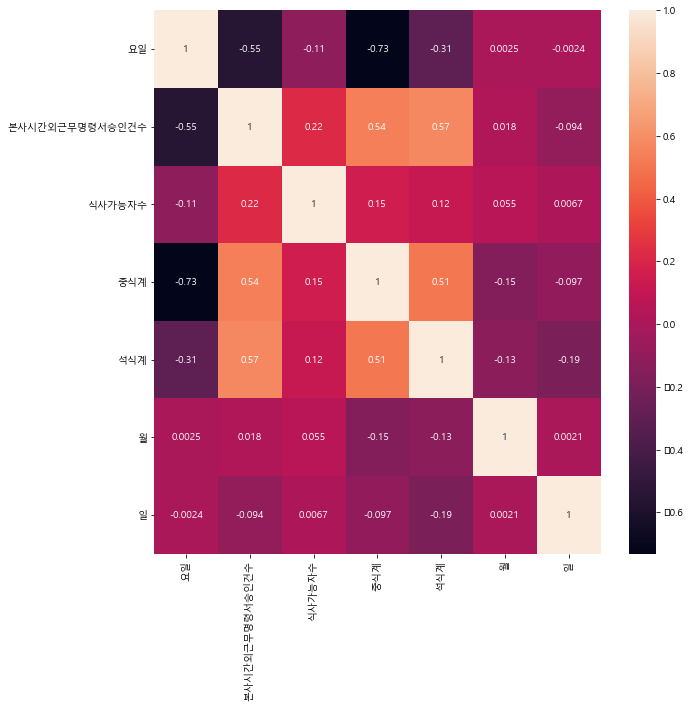

In [14]:
check = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '중식계', '석식계', '월', '일']]

plt.figure(figsize=(10,10)) # 도화지 크기를 키워줌
sns.heatmap(check.corr(), annot = True) # seaborn의 heatmap 함수에 train.corr() 상관계수를 넣어준다.
                                        # annot < 수치도 같이 나타내줌

## 점심과 저녁을 식수 인원을 예측할 2개 모델 생성

In [16]:
model1 = cat
model2 = cat

## 학습

In [17]:
model1.fit(x1_train, y1_train) #중식계
pred1 = model1.predict(x_test)

Learning rate set to 0.040347
0:	learn: 204.8682612	total: 138ms	remaining: 2m 17s
1:	learn: 199.5578839	total: 143ms	remaining: 1m 11s
2:	learn: 194.7356312	total: 152ms	remaining: 50.7s
3:	learn: 190.2472049	total: 156ms	remaining: 38.9s
4:	learn: 185.8154298	total: 159ms	remaining: 31.6s
5:	learn: 182.3471307	total: 160ms	remaining: 26.5s
6:	learn: 179.2740263	total: 162ms	remaining: 23s
7:	learn: 175.4790865	total: 164ms	remaining: 20.3s
8:	learn: 171.6896478	total: 165ms	remaining: 18.2s
9:	learn: 168.2611476	total: 168ms	remaining: 16.6s
10:	learn: 164.8574503	total: 170ms	remaining: 15.3s
11:	learn: 161.9023620	total: 173ms	remaining: 14.3s
12:	learn: 158.8741548	total: 175ms	remaining: 13.3s
13:	learn: 156.0716968	total: 177ms	remaining: 12.5s
14:	learn: 153.3479484	total: 179ms	remaining: 11.7s
15:	learn: 150.8519208	total: 180ms	remaining: 11.1s
16:	learn: 148.4092847	total: 182ms	remaining: 10.5s
17:	learn: 146.0669853	total: 184ms	remaining: 10s
18:	learn: 143.9375463	total

In [18]:
model2.fit(x2_train, y2_train) #석식계
pred2 = model2.predict(x_test)

Learning rate set to 0.040347
0:	learn: 136.5174356	total: 5.29ms	remaining: 5.28s
1:	learn: 134.1901331	total: 9.83ms	remaining: 4.91s
2:	learn: 131.8730875	total: 13.7ms	remaining: 4.57s
3:	learn: 129.8772507	total: 16.9ms	remaining: 4.2s
4:	learn: 127.5922571	total: 20.2ms	remaining: 4.02s
5:	learn: 125.3110873	total: 24.1ms	remaining: 3.99s
6:	learn: 123.9928784	total: 25.6ms	remaining: 3.63s
7:	learn: 121.7990503	total: 32.6ms	remaining: 4.04s
8:	learn: 120.3010989	total: 35.9ms	remaining: 3.95s
9:	learn: 118.7638360	total: 39.3ms	remaining: 3.89s
10:	learn: 117.1337684	total: 41.9ms	remaining: 3.77s
11:	learn: 115.5727409	total: 44.7ms	remaining: 3.68s
12:	learn: 114.2288760	total: 48.8ms	remaining: 3.71s
13:	learn: 112.9148813	total: 51.5ms	remaining: 3.62s
14:	learn: 111.6201669	total: 54ms	remaining: 3.55s
15:	learn: 110.3724115	total: 57.4ms	remaining: 3.53s
16:	learn: 109.0904104	total: 59.4ms	remaining: 3.43s
17:	learn: 107.8721284	total: 61.5ms	remaining: 3.35s
18:	learn: 

In [24]:
from sklearn.model_selection import KFold

In [25]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

In [26]:
model1 = cat
models1 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x1_train):
    x1_t = x1_train.iloc[train_idx]
    y1_t = y1_train.iloc[train_idx]
    x1_val = x1_train.iloc[val_idx]
    y1_val = y1_train.iloc[val_idx]
    
    models1.append(model1.fit(x1_t, y1_t, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))

preds1 = []
for model1 in models1:
    preds1.append(model1.predict(x_test))    


model2 = cat
models2 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x2_train):
    x2_t = x2_train.iloc[train_idx]
    y2_t = y2_train.iloc[train_idx]
    x2_val = x2_train.iloc[val_idx]
    y2_val = y2_train.iloc[val_idx]
    
    models2.append(model2.fit(x2_t, y2_t, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))
    

preds2 = []
for model2 in models2:
    preds2.append(model2.predict(x_test))

Learning rate set to 0.045759
0:	learn: 204.3532518	test: 204.5155751	best: 204.5155751 (0)	total: 1.37ms	remaining: 1.37s
100:	learn: 90.5997913	test: 104.2945477	best: 104.2945477 (100)	total: 195ms	remaining: 1.74s
200:	learn: 78.6370419	test: 98.7962317	best: 98.7466749 (199)	total: 354ms	remaining: 1.41s
300:	learn: 69.7200366	test: 97.8456161	best: 97.8456161 (300)	total: 509ms	remaining: 1.18s
400:	learn: 63.2363531	test: 97.2638331	best: 97.1715157 (397)	total: 669ms	remaining: 999ms
500:	learn: 58.1789396	test: 97.1753290	best: 97.1006505 (496)	total: 826ms	remaining: 823ms
600:	learn: 53.3586295	test: 97.4348971	best: 97.0150695 (528)	total: 1.03s	remaining: 683ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 97.01506952
bestIteration = 528

Shrink model to first 529 iterations.
Learning rate set to 0.045759
0:	learn: 202.0844715	test: 209.2302584	best: 209.2302584 (0)	total: 1.71ms	remaining: 1.7s
100:	learn: 90.9625147	test: 99.9775700	best: 99.9775700 

In [27]:


pred1 = np.mean(preds1, axis=0)
pred2 = np.mean(preds2, axis=0)

## 추론

In [28]:

submission['중식계'] = pred1

submission['석식계'] = pred2

## 결과 제출

In [29]:
submission.to_csv('catKfold.csv', index=False)

In [60]:
# 여태까지 최고성적은 요일, 일, 월만 추가한 것이었음.